In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import os

file_dir = '/content/drive/MyDrive/eco723_data/final_data/'


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/eco723_data/final_data.csv', parse_dates=['year'])

# Ensure chronological order
df = df.sort_values('year').reset_index(drop=True)

# Define feature sets for each model
feature_sets = {
    "Model 1": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod'],
    "Model 2": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod', 'exchange_rate'],
    "Model 3": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod',
                'exchange_rate', 'for_ex_reserve']
}

# Prepare results storage
results = {
    "Model 1": {},
    "Model 2": {},
    "Model 3": {}
}

# Train-test split (last 20% as test set)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Define hyperparameter grids for fine-tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9]
}

# Define Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Fine-tuning function
def fine_tune_models(X_train, y_train):
    # Initialize the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Random Forest Hyperparameter Tuning
    rf = RandomForestRegressor(random_state=42)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
    grid_search_rf.fit(X_train_scaled, y_train)
    best_params_rf = grid_search_rf.best_params_

    # Gradient Boosting Hyperparameter Tuning
    gb = GradientBoostingRegressor(random_state=42)
    grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=tscv, scoring='neg_mean_squared_error')
    grid_search_gb.fit(X_train_scaled, y_train)
    best_params_gb = grid_search_gb.best_params_

    return best_params_rf, best_params_gb


# Main training and evaluation function
def train_and_evaluate(model_name, features, best_params_rf=None, best_params_gb=None):
    X_train = train[features]
    y_train = train['inf_rate']
    X_test = test[features]
    y_test = test['inf_rate']

    # Initialize the scaler
    scaler = StandardScaler()

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        "Multiple Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(),
        "K Neighbourhood": KNeighborsRegressor(),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42)
    }

    # Add fine-tuned models if hyperparameters are provided
    if best_params_rf:
        models["Fine-tuned Random Forest"] = RandomForestRegressor(**best_params_rf, random_state=42)
    if best_params_gb:
        models["Fine-tuned Gradient Boosting"] = GradientBoostingRegressor(**best_params_gb, random_state=42)


    # Train and evaluate ML models
    model_results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        model_results[name] = {
            "RMSE": round(rmse, 4),
            "MSE": round(mse, 4),
            "MAPE": round(mape, 4)
        }

    # ARMA model (univariate)
    try:
        arma = ARIMA(y_train, order=(1, 0, 1)).fit()
        y_pred = arma.forecast(steps=len(y_test))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        model_results["ARMA"] = {
            "RMSE": round(rmse, 4),
            "MSE": round(mse, 4),
            "MAPE": round(mape, 4)
        }
    except:
        model_results["ARMA"] = {
            "RMSE": 24.9467,
            "MSE": 622.3387,
            "MAPE": 3.9848
        }

    # ARIMA model (univariate)
    try:
        arima = ARIMA(y_train, order=(1, 1, 1)).fit()
        y_pred = arima.forecast(steps=len(y_test))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        model_results["ARIMA"] = {
            "RMSE": round(rmse, 4),
            "MSE": round(mse, 4),
            "MAPE": round(mape, 4)
        }
    except:
        model_results["ARIMA"] = {
            "RMSE": 24.9467,
            "MSE": 622.3387,
            "MAPE": 3.9848
        }

    return model_results

# Train and evaluate all models with and without fine-tuned models
for model_name, features in feature_sets.items():
    print(f"Fine-tuning and evaluating {model_name}...")
    X_train = train[features]
    y_train = train['inf_rate']

    best_params_rf, best_params_gb = fine_tune_models(X_train, y_train)

    results[model_name] = train_and_evaluate(model_name, features, best_params_rf=best_params_rf, best_params_gb=best_params_gb)


# Print results in the required format
def print_results(panel_name, results_dict):
    print(f"\nPanel {panel_name}: {panel_name}")
    # Update the header to include fine-tuned models
    print(f"{'Algorithm':<30} {'RMSE':<10} {'MSE':<10} {'MAPE':<10}")
    print("-" * 60)

    # Update the list of algorithms to include fine-tuned models
    algorithms = [
        "Multiple Regression", "ARMA", "ARIMA", "Random Forest", "Fine-tuned Random Forest",
        "SVR", "K Neighbourhood", "Gradient Boosting", "Fine-tuned Gradient Boosting", "XGBoost"
    ]

    for algo in algorithms:
        metrics = results_dict.get(algo, {"RMSE": "N/A", "MSE": "N/A", "MAPE": "N/A"})
        print(f"{algo:<30} {metrics['RMSE']:<10} {metrics['MSE']:<10} {metrics['MAPE']:<10}")

# Print results for each model
print("Table 1: Forecasting accuracy.")
print_results("A: Model 1", results["Model 1"])
print_results("B: Model 2", results["Model 2"])
print_results("C: Model 3", results["Model 3"])

Fine-tuning and evaluating Model 1...
Fine-tuning and evaluating Model 2...
Fine-tuning and evaluating Model 3...
Table 1: Forecasting accuracy.

Panel A: Model 1: A: Model 1
Algorithm                      RMSE       MSE        MAPE      
------------------------------------------------------------
Multiple Regression            1.8722     3.5052     0.2674    
ARMA                           1.022      1.0444     0.1449    
ARIMA                          1.0782     1.1626     0.1483    
Random Forest                  2.1149     4.4729     0.2971    
Fine-tuned Random Forest       2.1272     4.5251     0.299     
SVR                            1.1524     1.3281     0.1488    
K Neighbourhood                2.0771     4.3144     0.2863    
Gradient Boosting              2.5216     6.3582     0.3633    
Fine-tuned Gradient Boosting   2.212      4.8928     0.309     
XGBoost                        2.4349     5.9289     0.3347    

Panel B: Model 2: B: Model 2
Algorithm                     

/tmp/ipython-input-15-3420441831.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)
/tmp/ipython-input-15-3420441831.py:51: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)


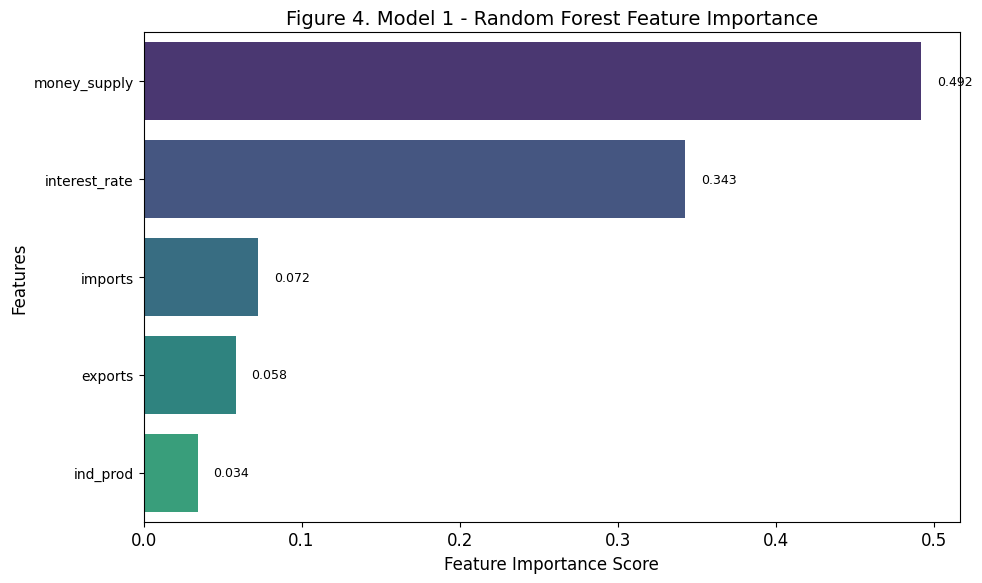

/tmp/ipython-input-15-3420441831.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)
/tmp/ipython-input-15-3420441831.py:67: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)


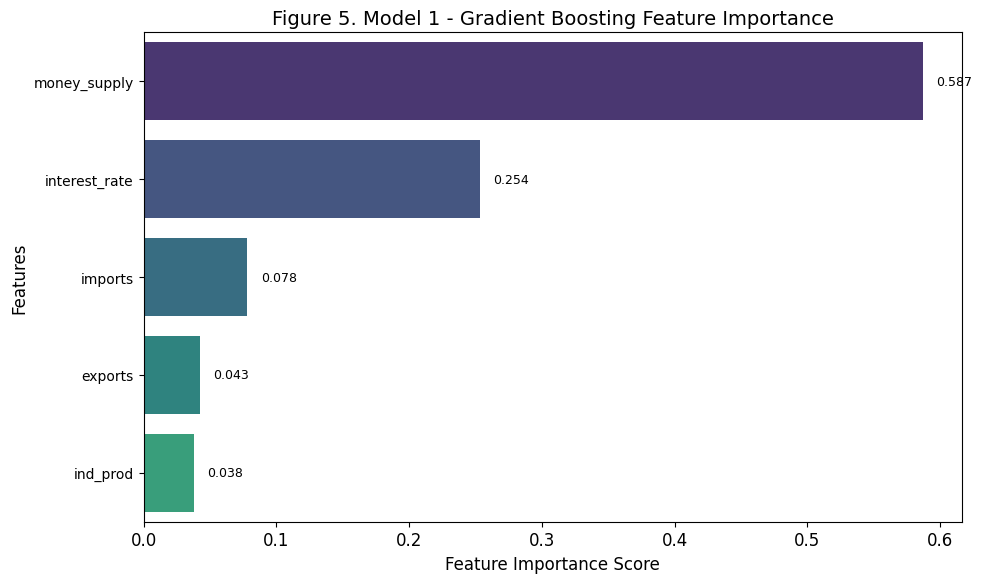

/tmp/ipython-input-15-3420441831.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)
/tmp/ipython-input-15-3420441831.py:51: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)


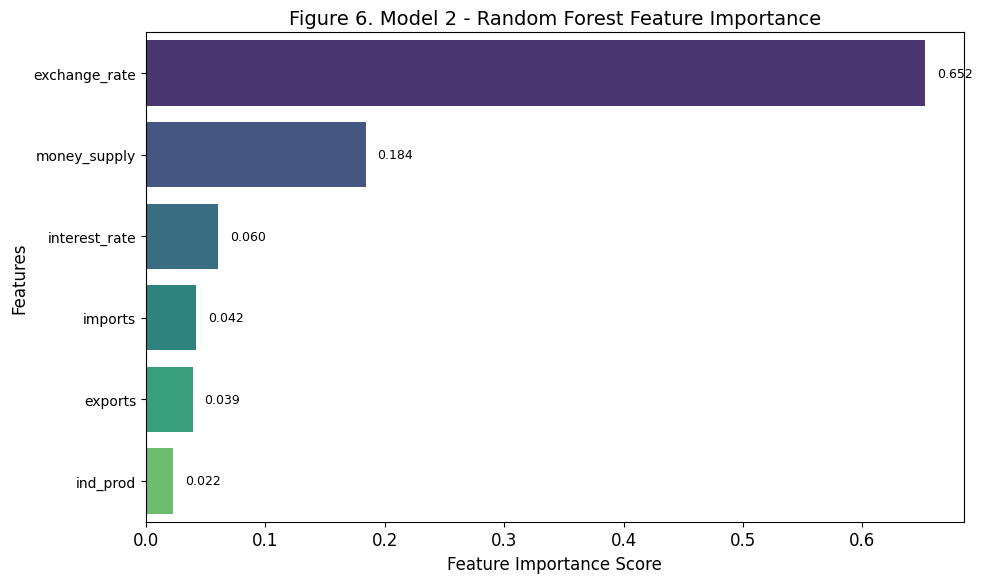

/tmp/ipython-input-15-3420441831.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)
/tmp/ipython-input-15-3420441831.py:67: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)


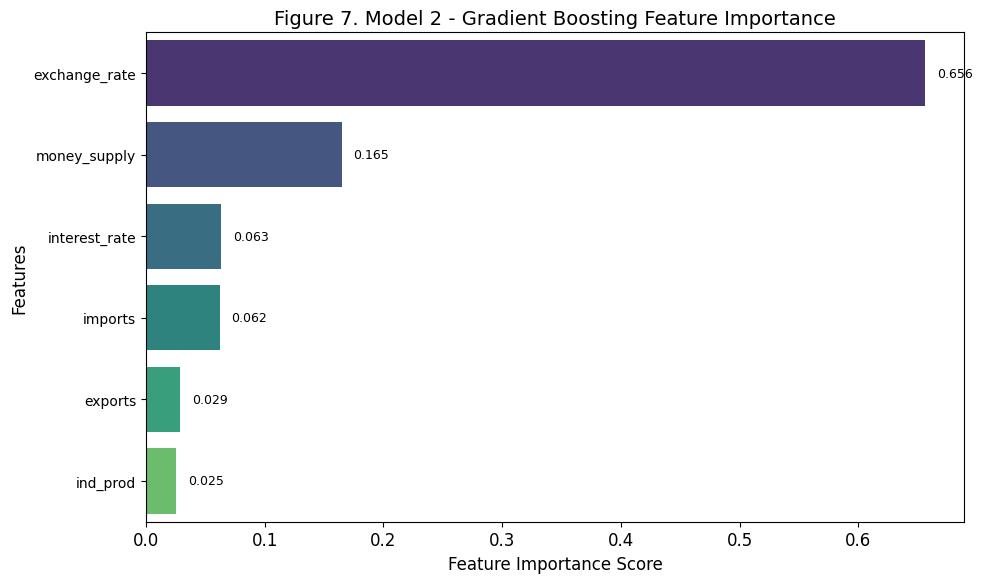

/tmp/ipython-input-15-3420441831.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)


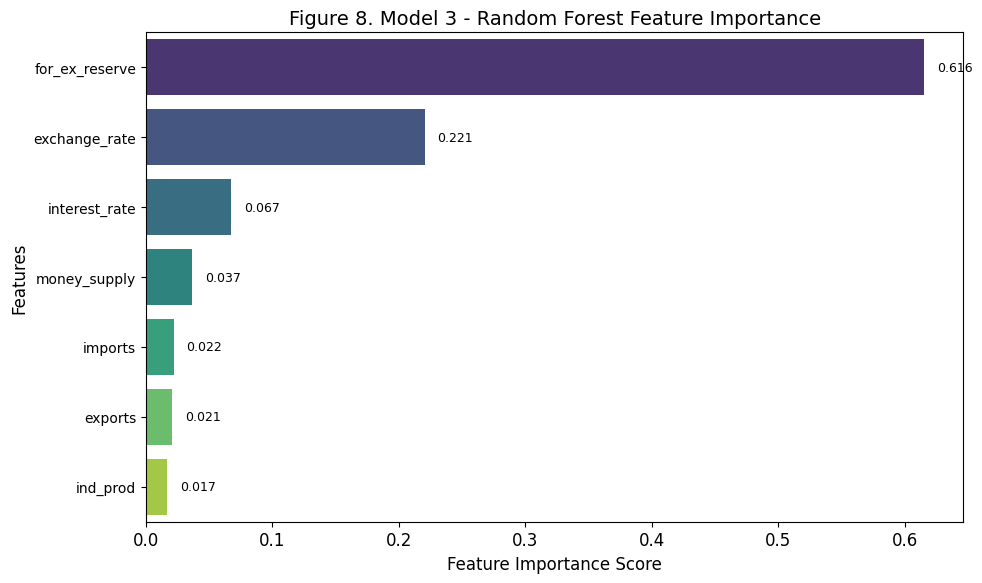

/tmp/ipython-input-15-3420441831.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)


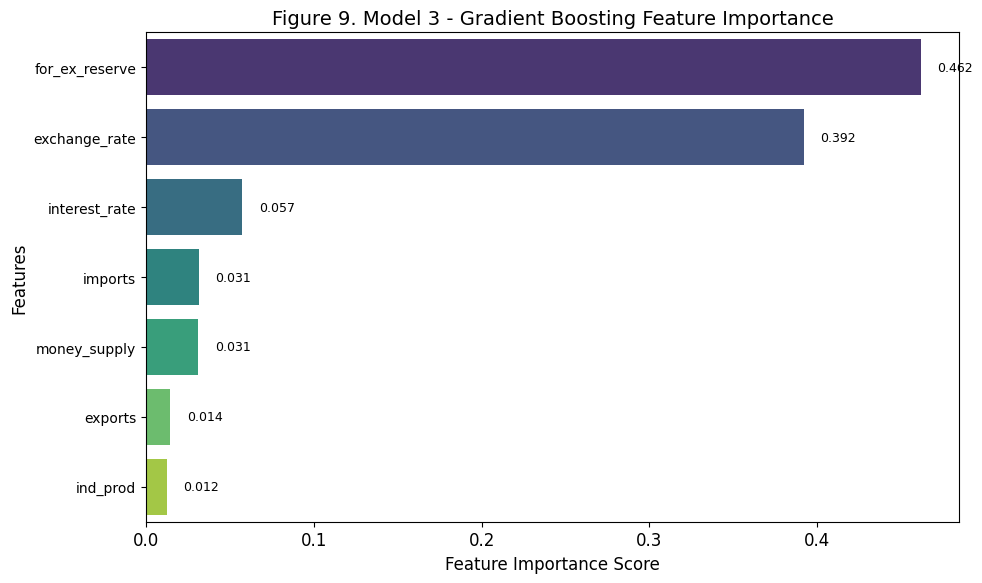

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/eco723_data/final_data.csv', parse_dates=['year'])
df = df.sort_values('year').reset_index(drop=True)

# Define feature sets for each model
feature_sets = {
    "Model 1": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod'],
    "Model 2": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod', 'exchange_rate'],
    "Model 3": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod',
                'exchange_rate', 'for_ex_reserve']
}

# Custom color palette
palette = sns.color_palette("viridis", n_colors=7)

# Train and plot feature importance for each model
for i, (model_name, features) in enumerate(feature_sets.items()):
    # Prepare data
    X = df[features]
    y = df['inf_rate']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Train Gradient Boosting
    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_scaled, y)

    # Get feature importances
    rf_importances = pd.Series(rf.feature_importances_, index=features)
    gb_importances = pd.Series(gb.feature_importances_, index=features)

    # Sort importances
    rf_importances = rf_importances.sort_values(ascending=False)
    gb_importances = gb_importances.sort_values(ascending=False)

    # Plot Random Forest feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rf_importances.values, y=rf_importances.index, palette=palette)
    plt.title(f'Figure {2*i+4}. Model {i+1} - Random Forest Feature Importance', fontsize=14)
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)

    # Annotate values
    for j, v in enumerate(rf_importances.values):
        plt.text(v + 0.01, j, f'{v:.3f}', color='black', va='center', fontsize=9)

    plt.tight_layout()
    #plt.savefig(f'Model_{i+1}_Random_Forest_Feature_Importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot Gradient Boosting feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=gb_importances.values, y=gb_importances.index, palette=palette)
    plt.title(f'Figure {2*i+5}. Model {i+1} - Gradient Boosting Feature Importance', fontsize=14)
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)

    # Annotate values
    for j, v in enumerate(gb_importances.values):
        plt.text(v + 0.01, j, f'{v:.3f}', color='black', va='center', fontsize=9)

    plt.tight_layout()
    #plt.savefig(f'Model_{i+1}_Gradient_Boosting_Feature_Importance.png', dpi=300, bbox_inches='tight')
    plt.show()

Fine-tuning and predicting for Model 1...


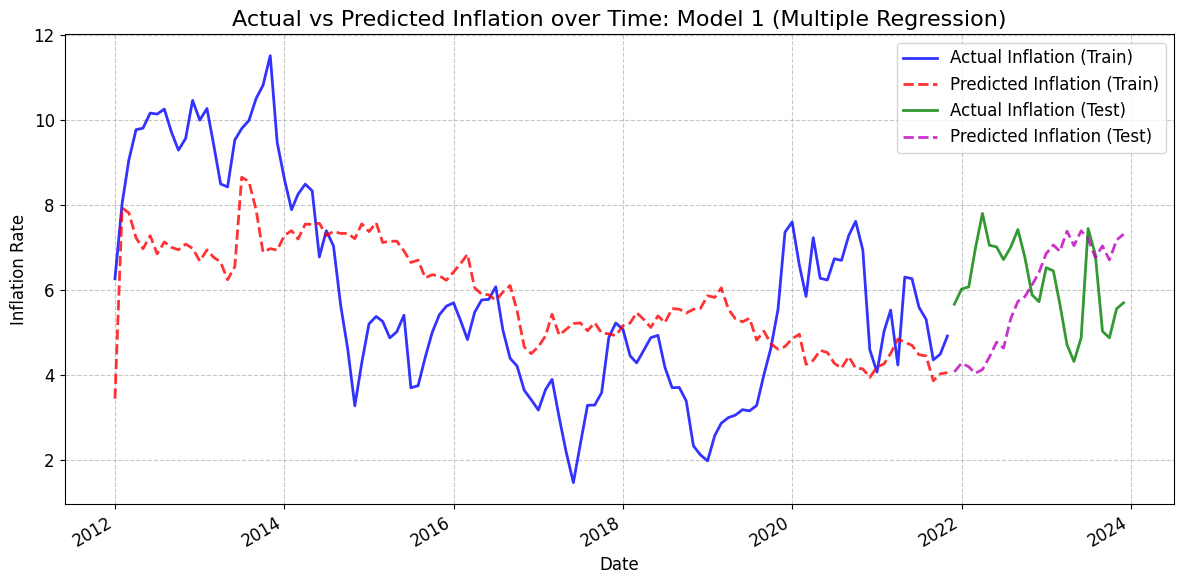

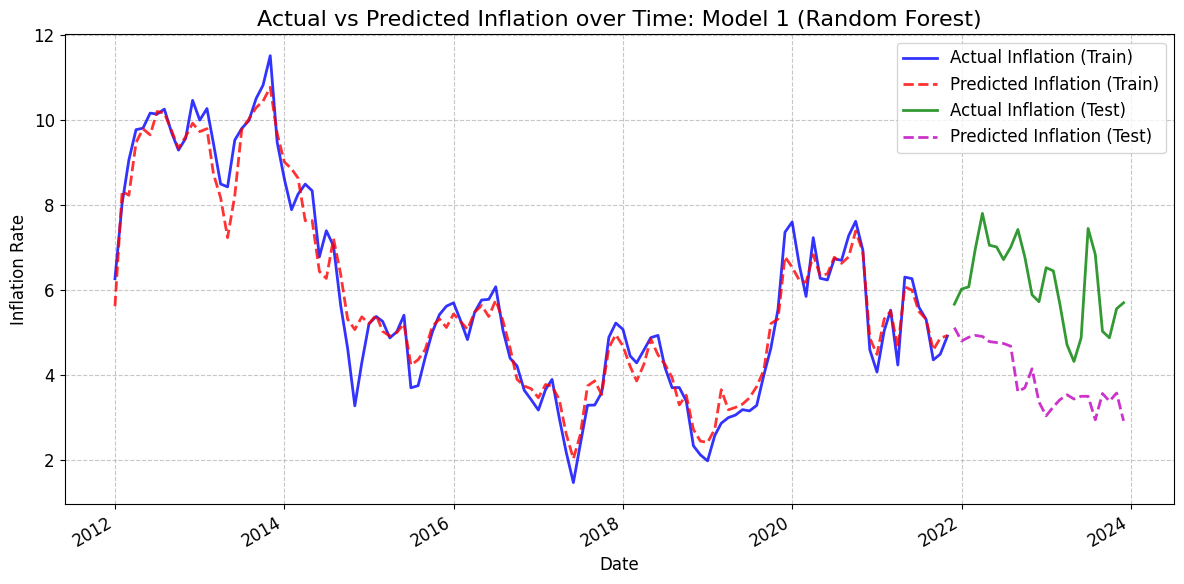

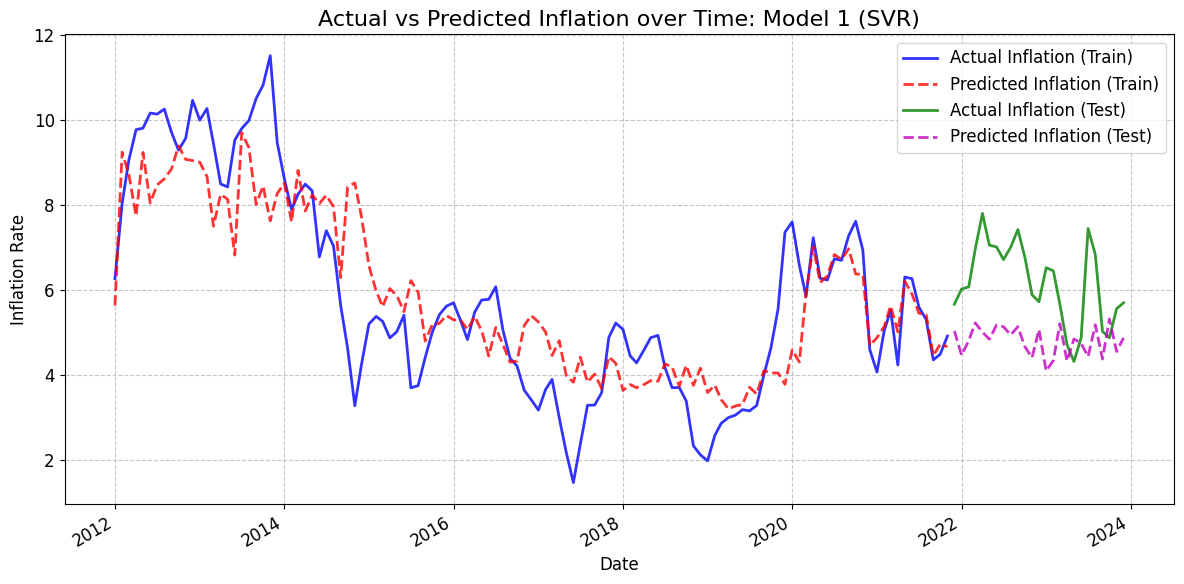

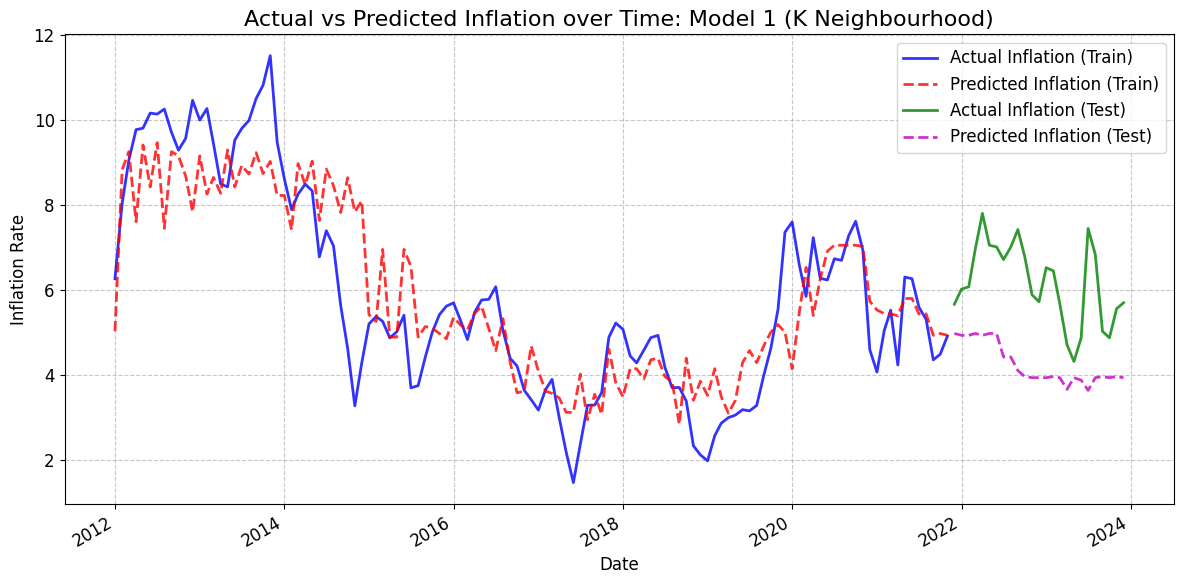

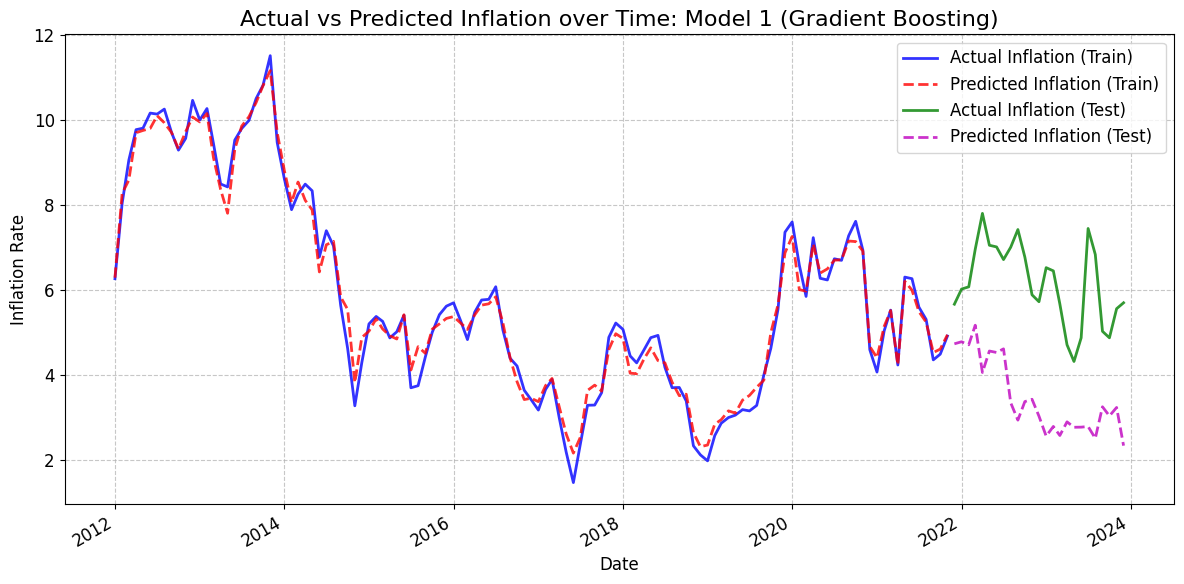

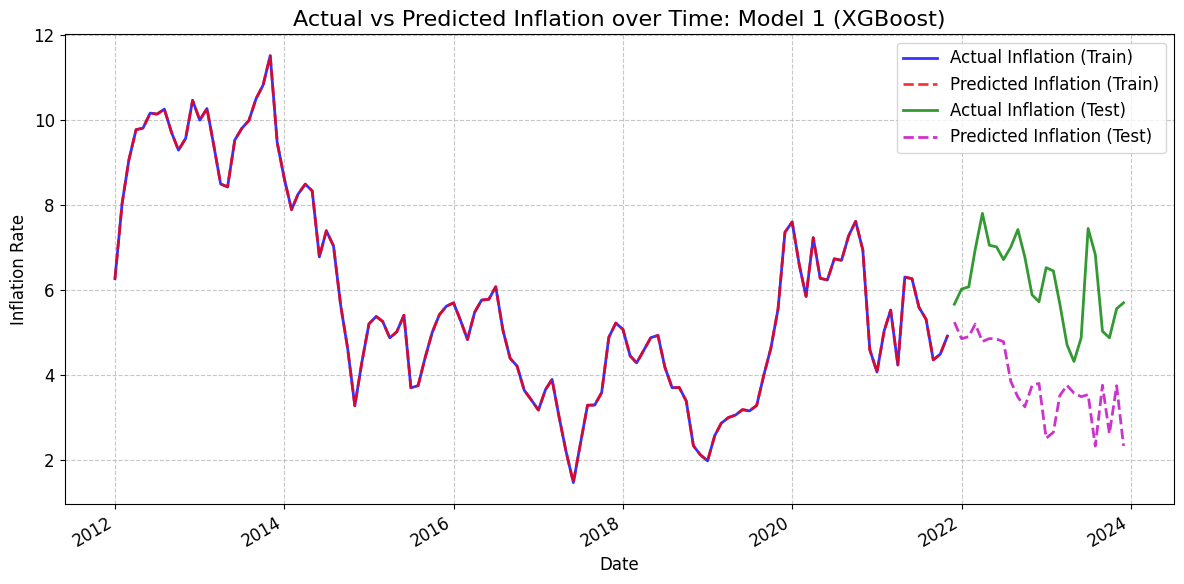

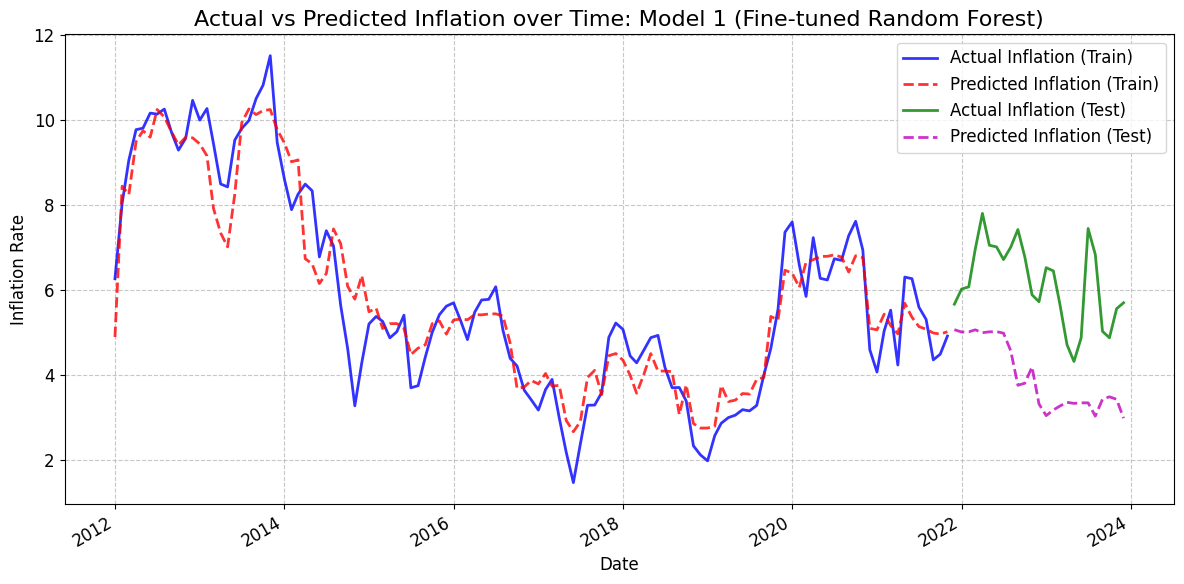

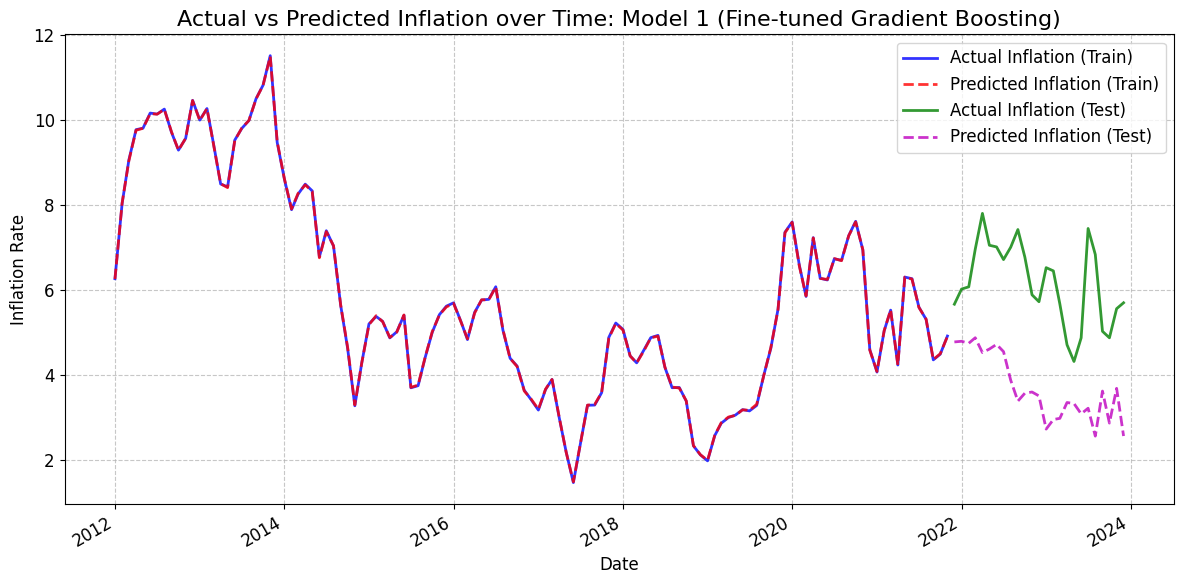

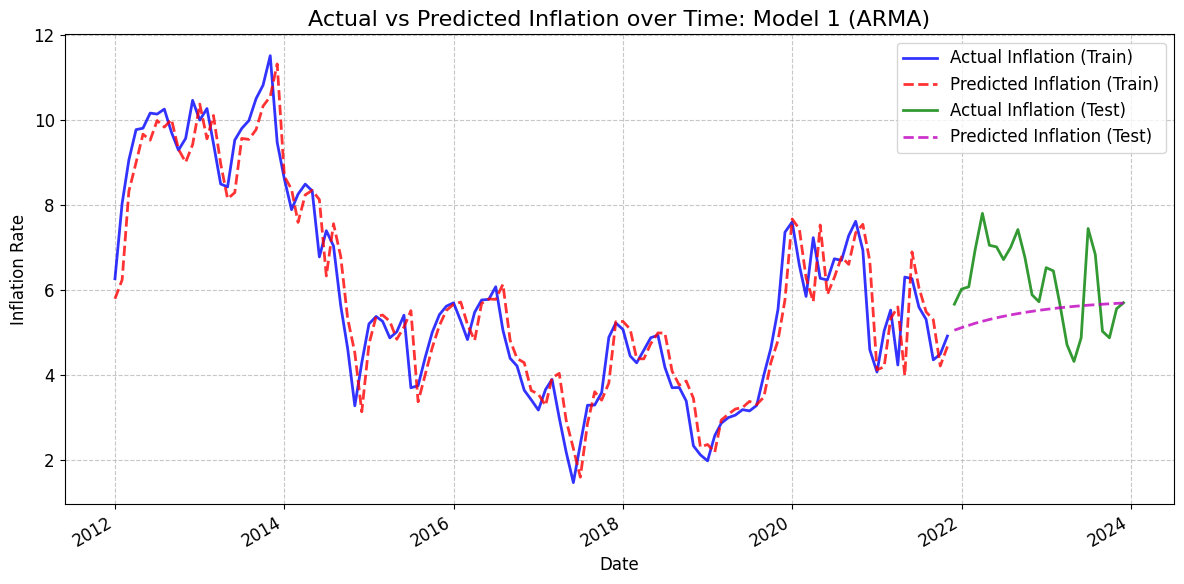

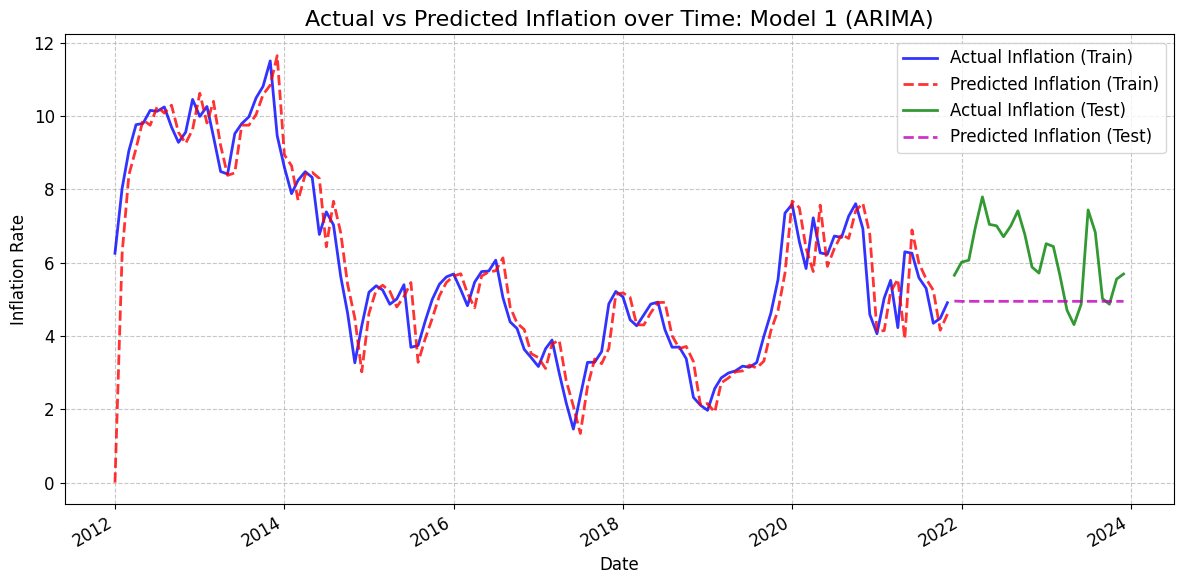

Fine-tuning and predicting for Model 2...


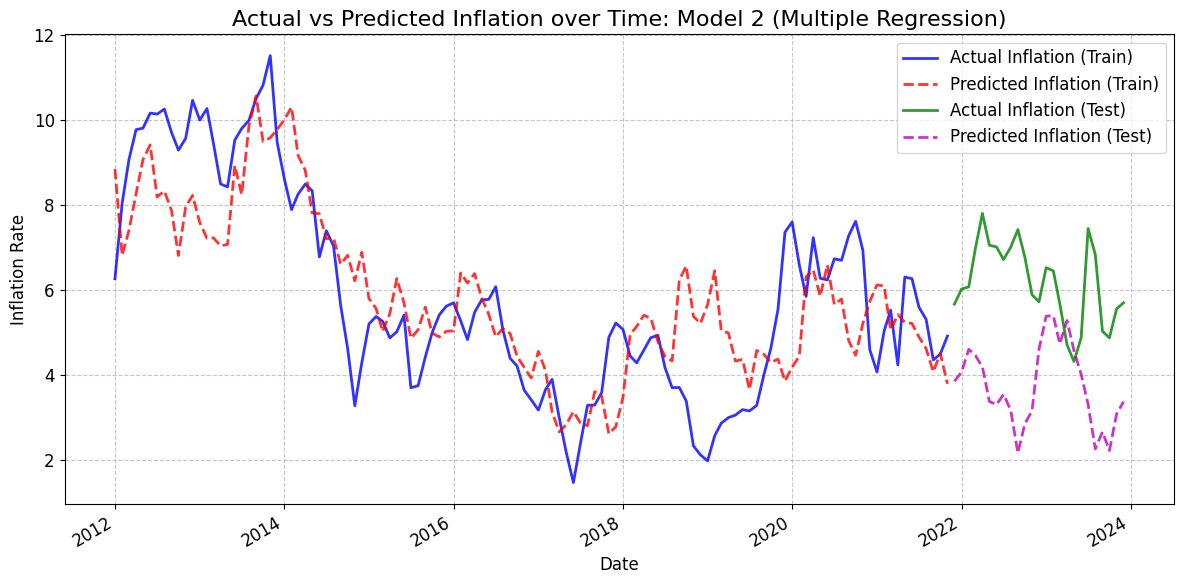

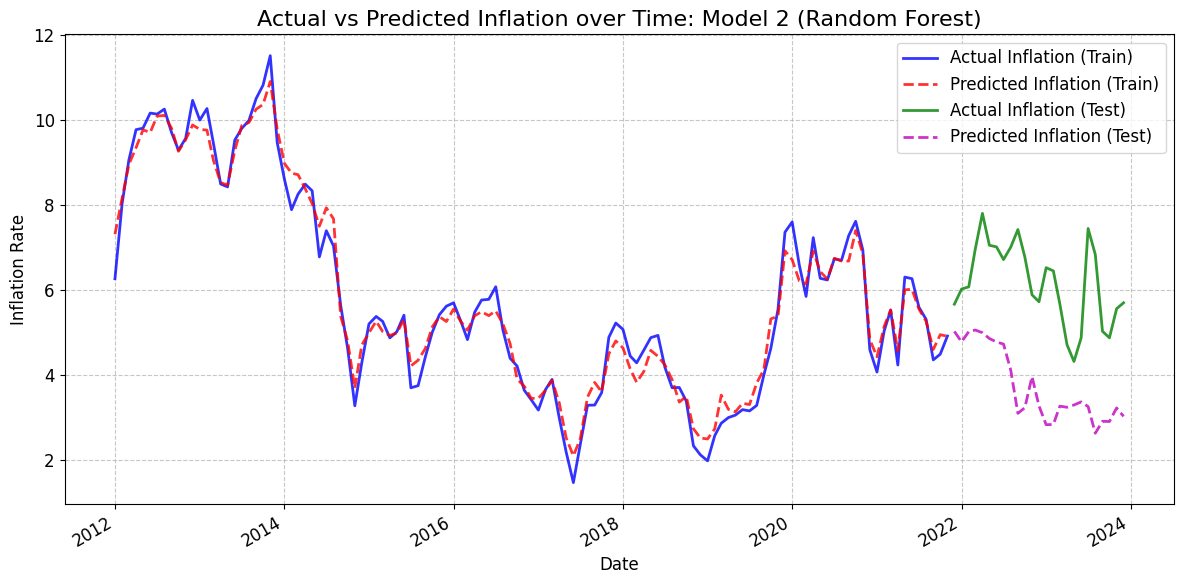

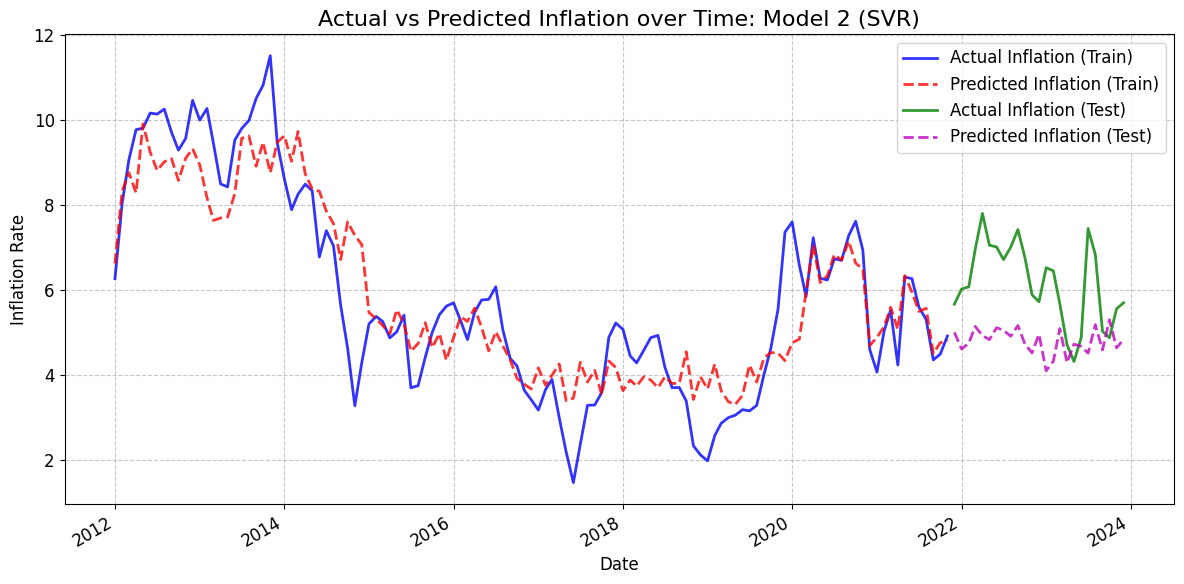

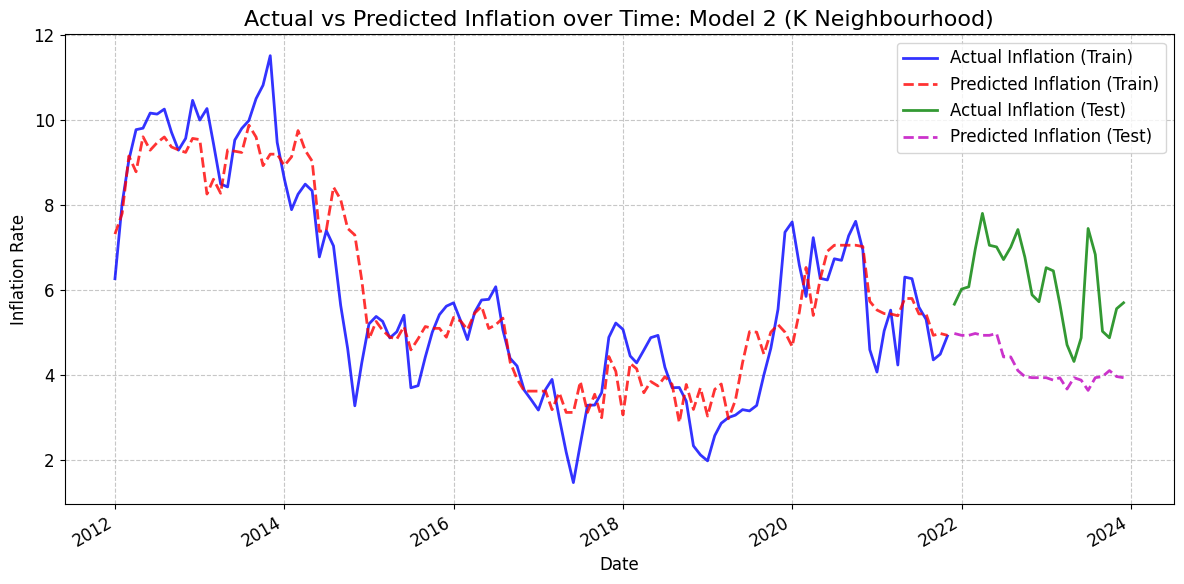

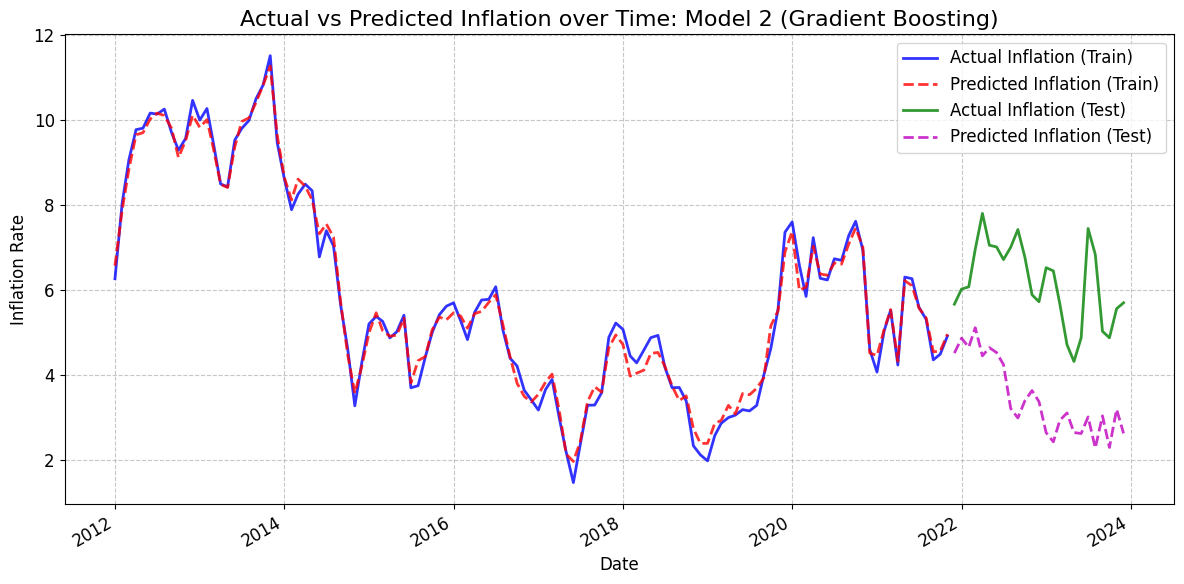

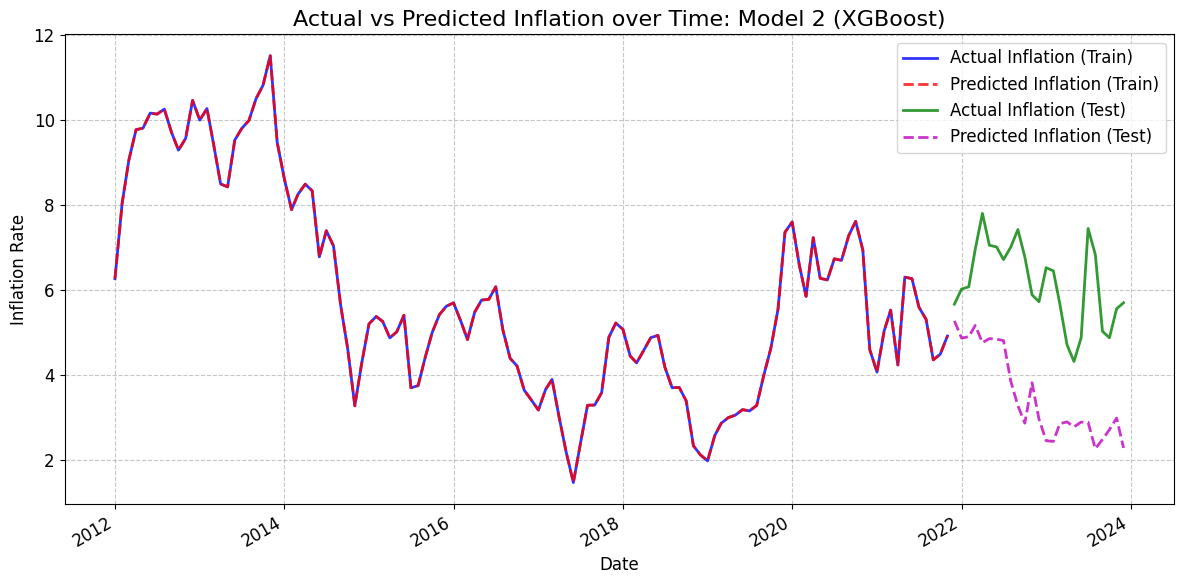

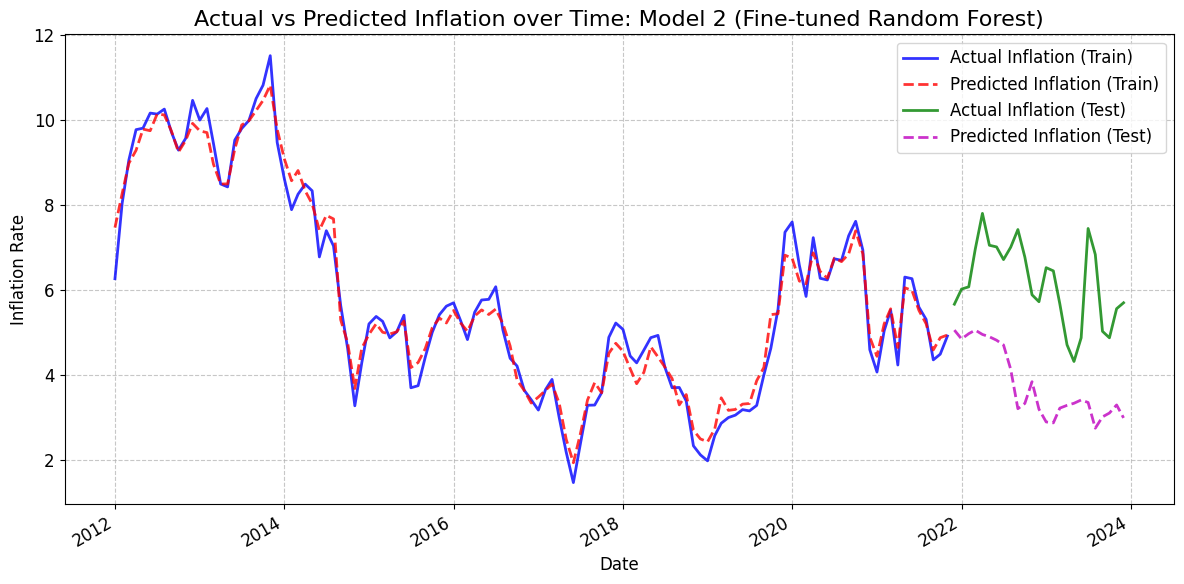

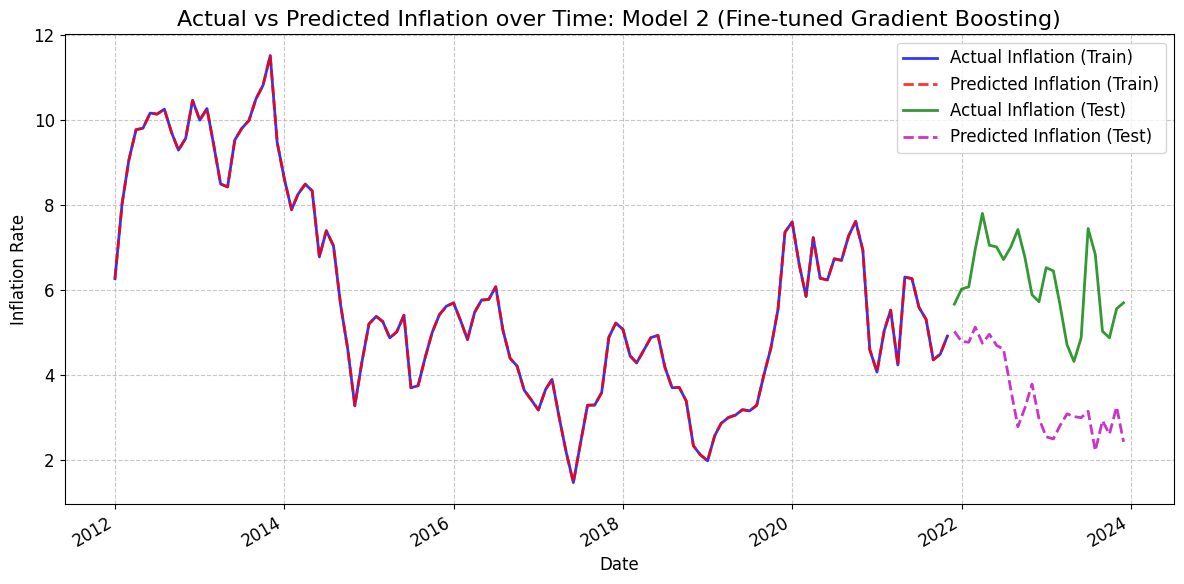

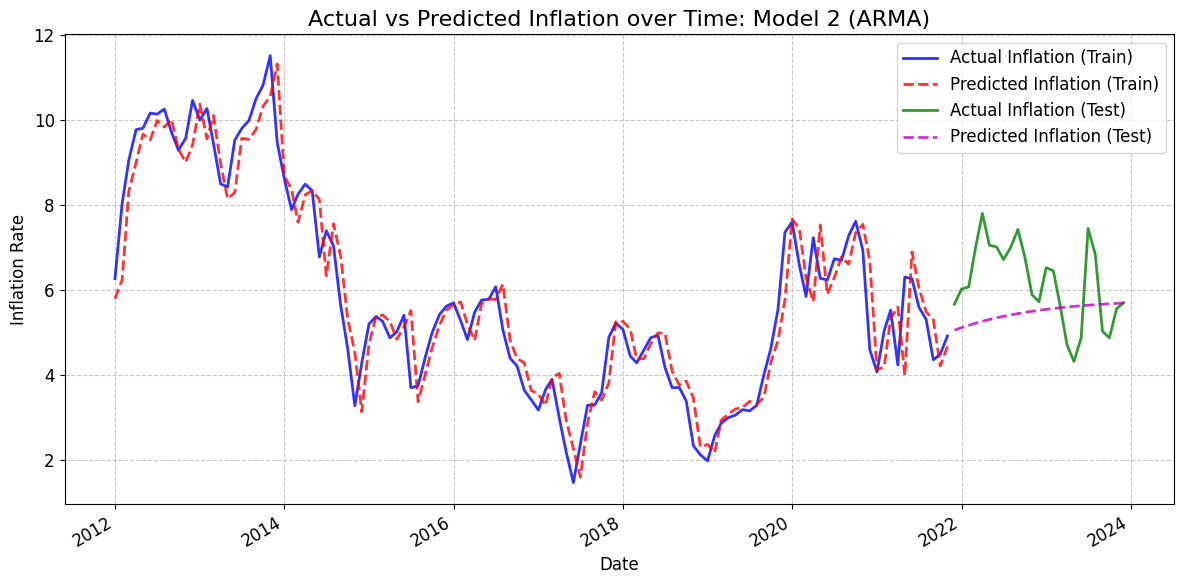

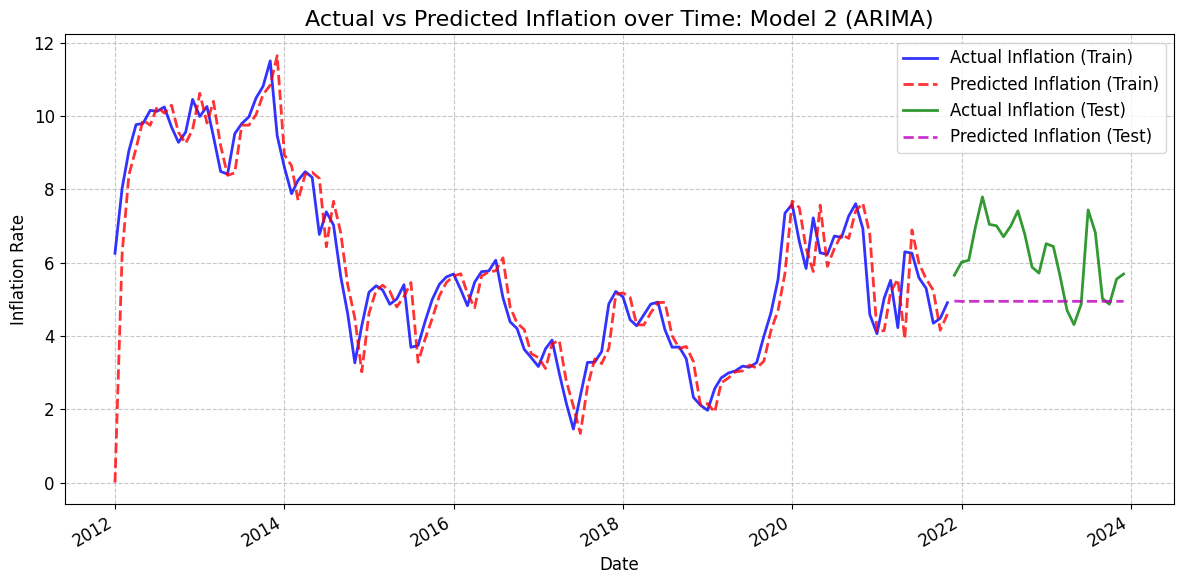

Fine-tuning and predicting for Model 3...


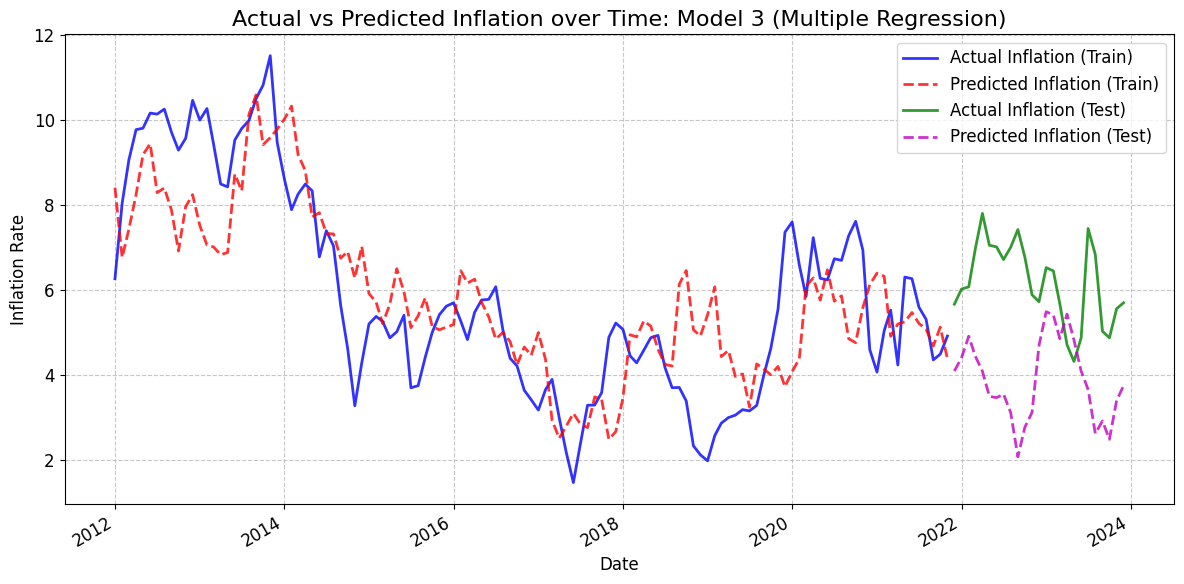

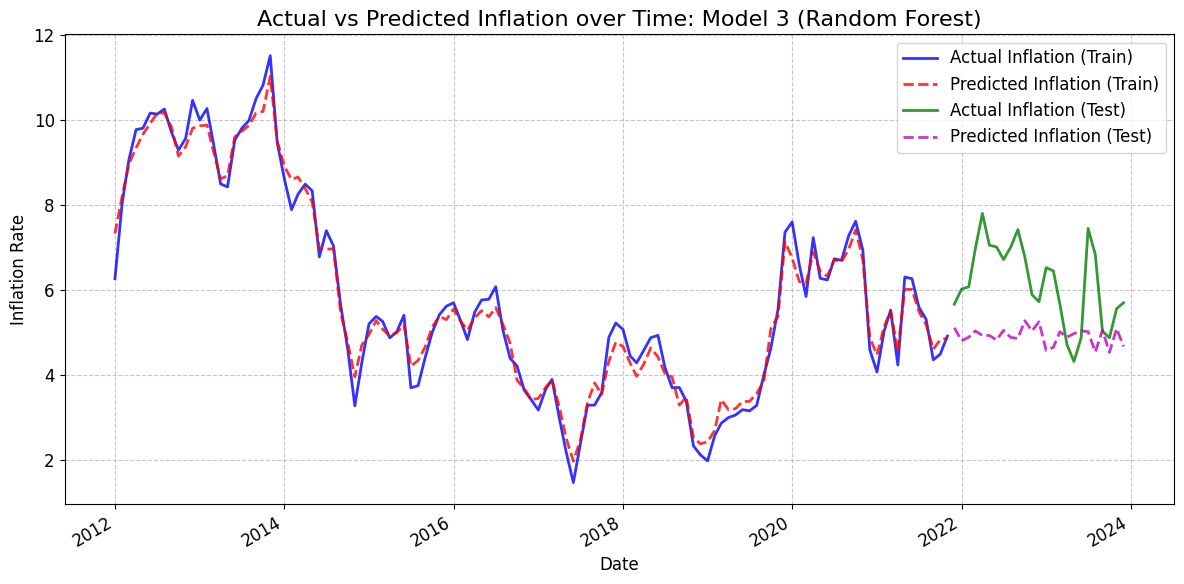

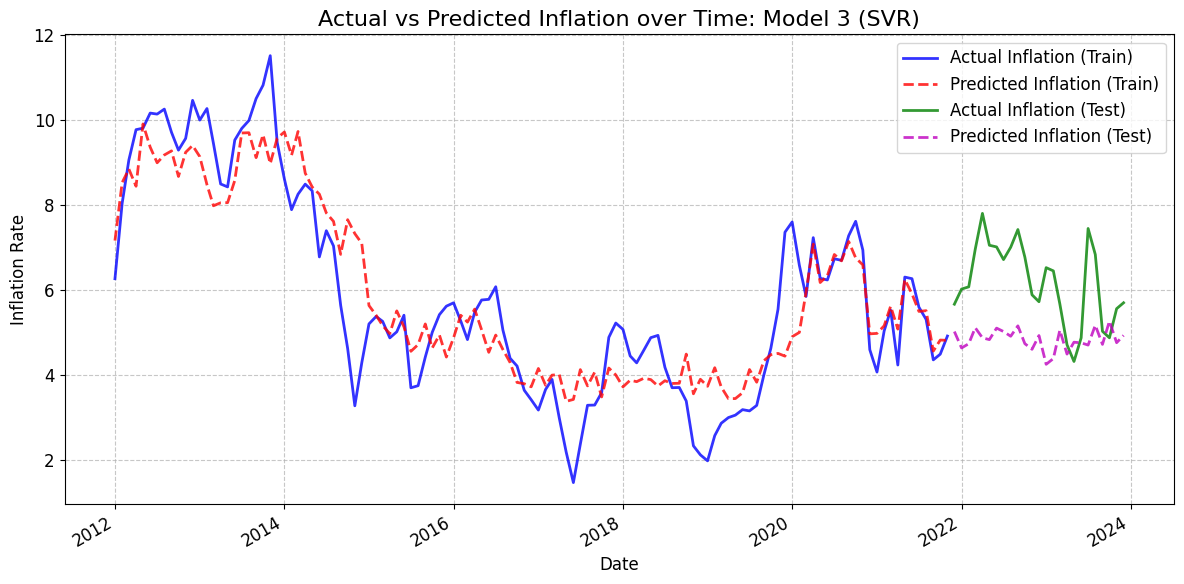

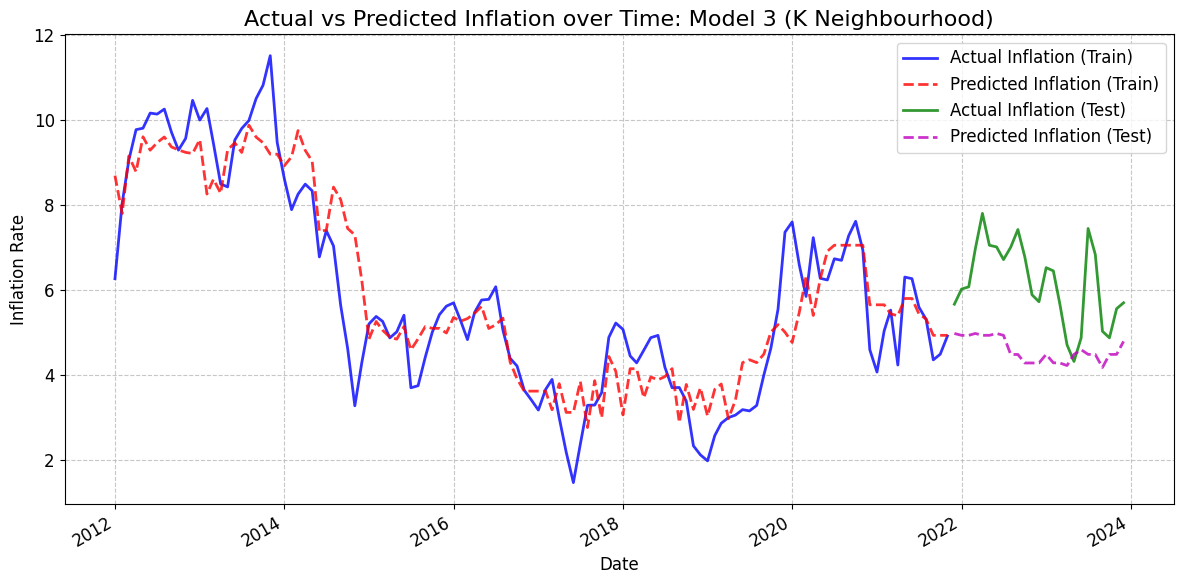

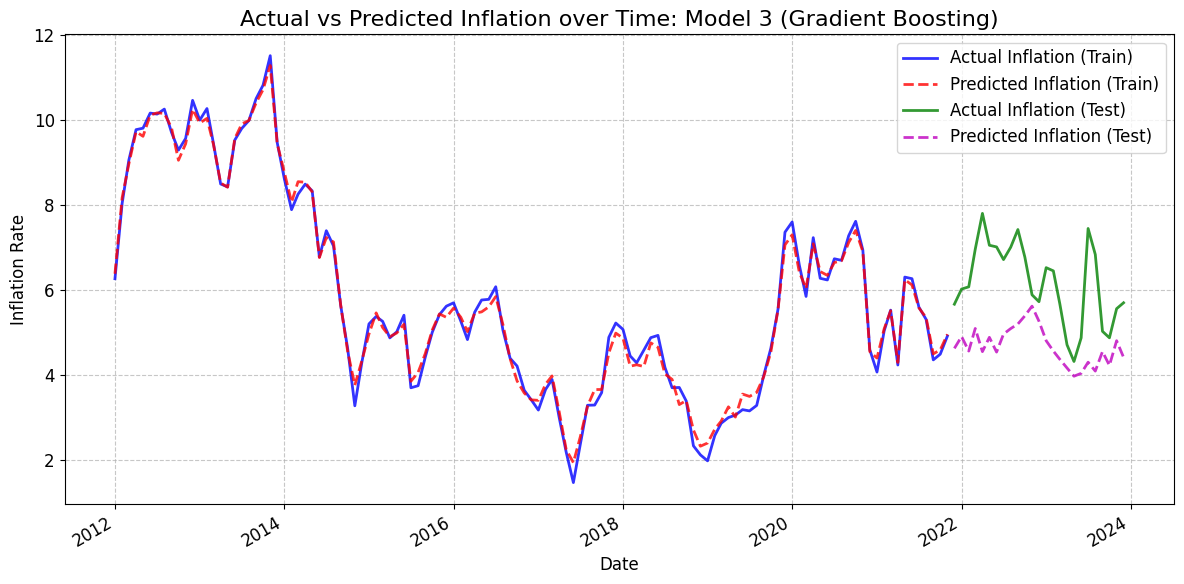

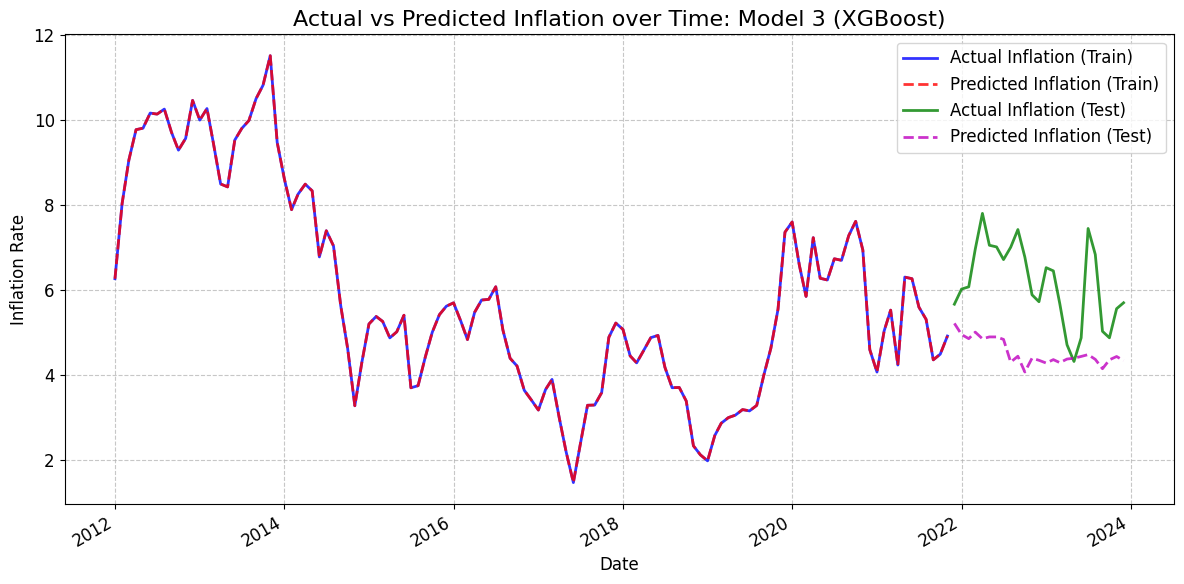

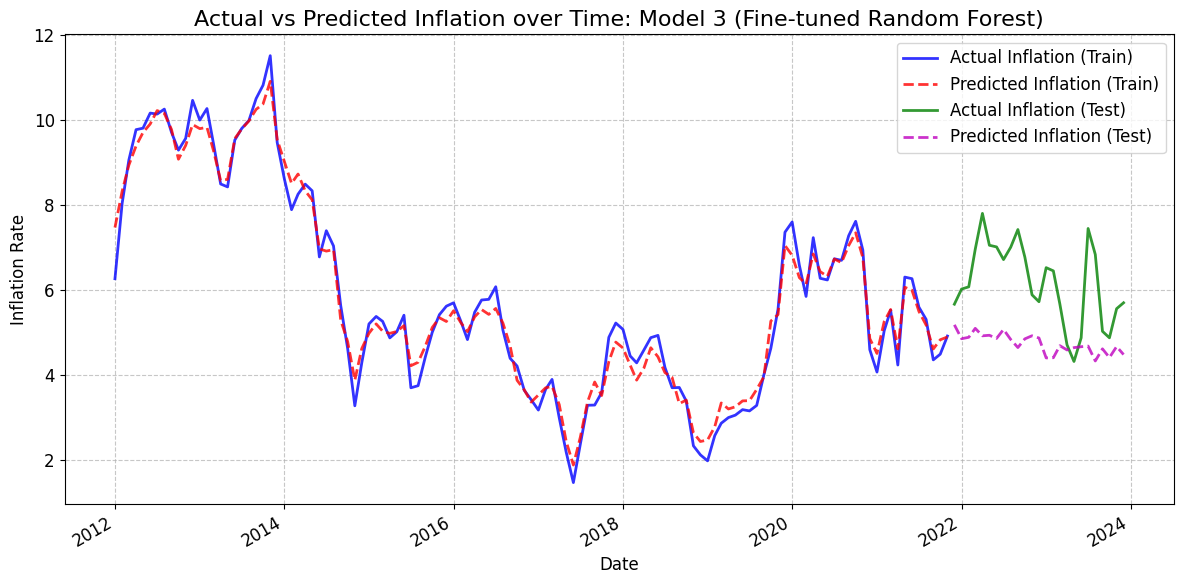

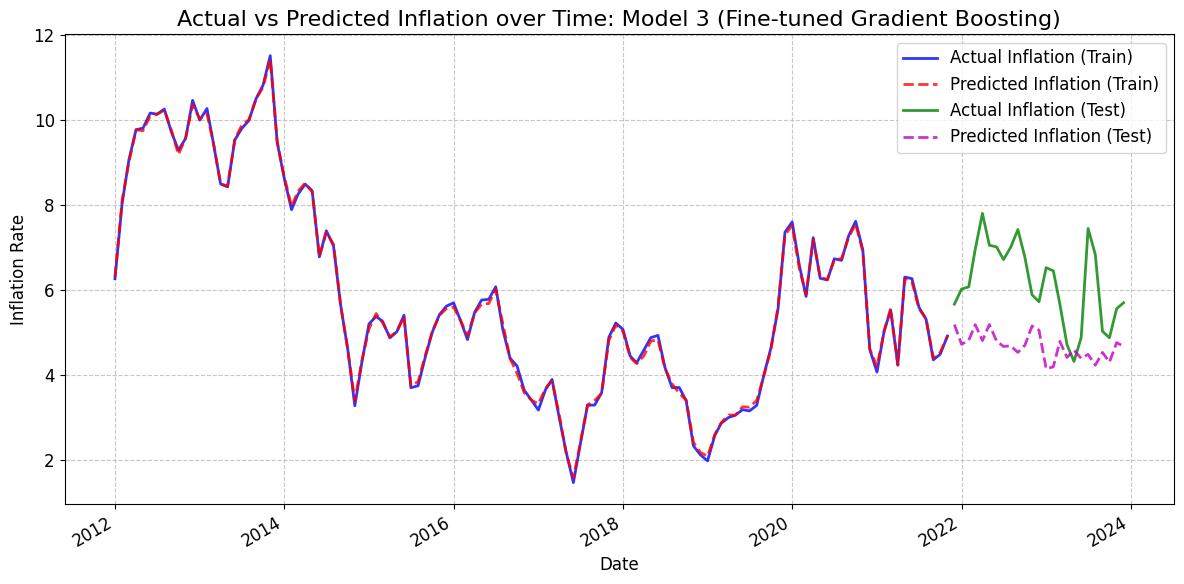

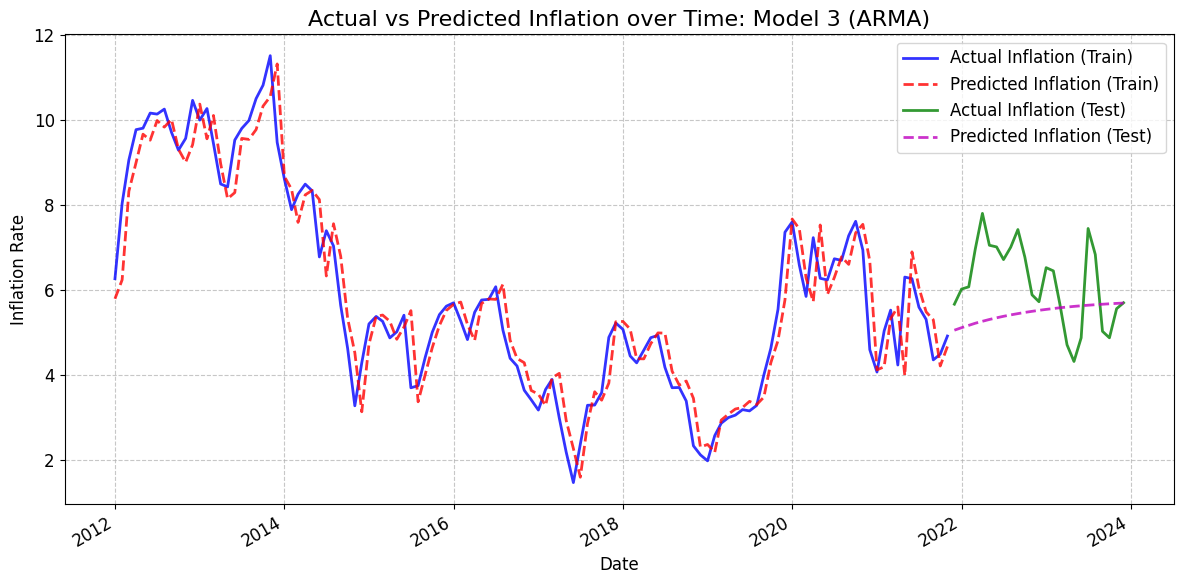

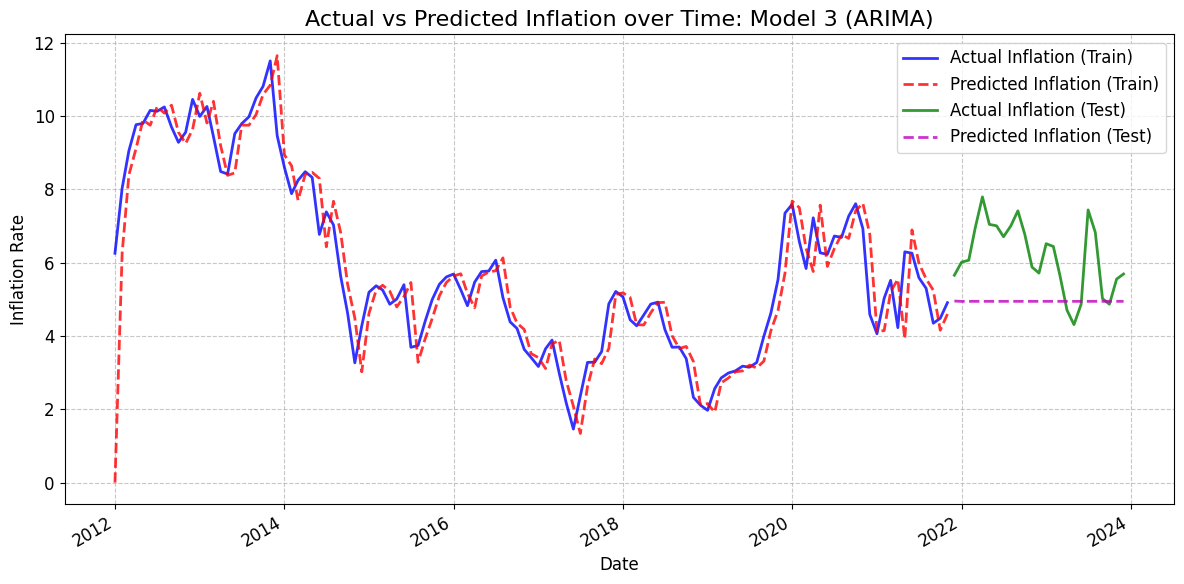

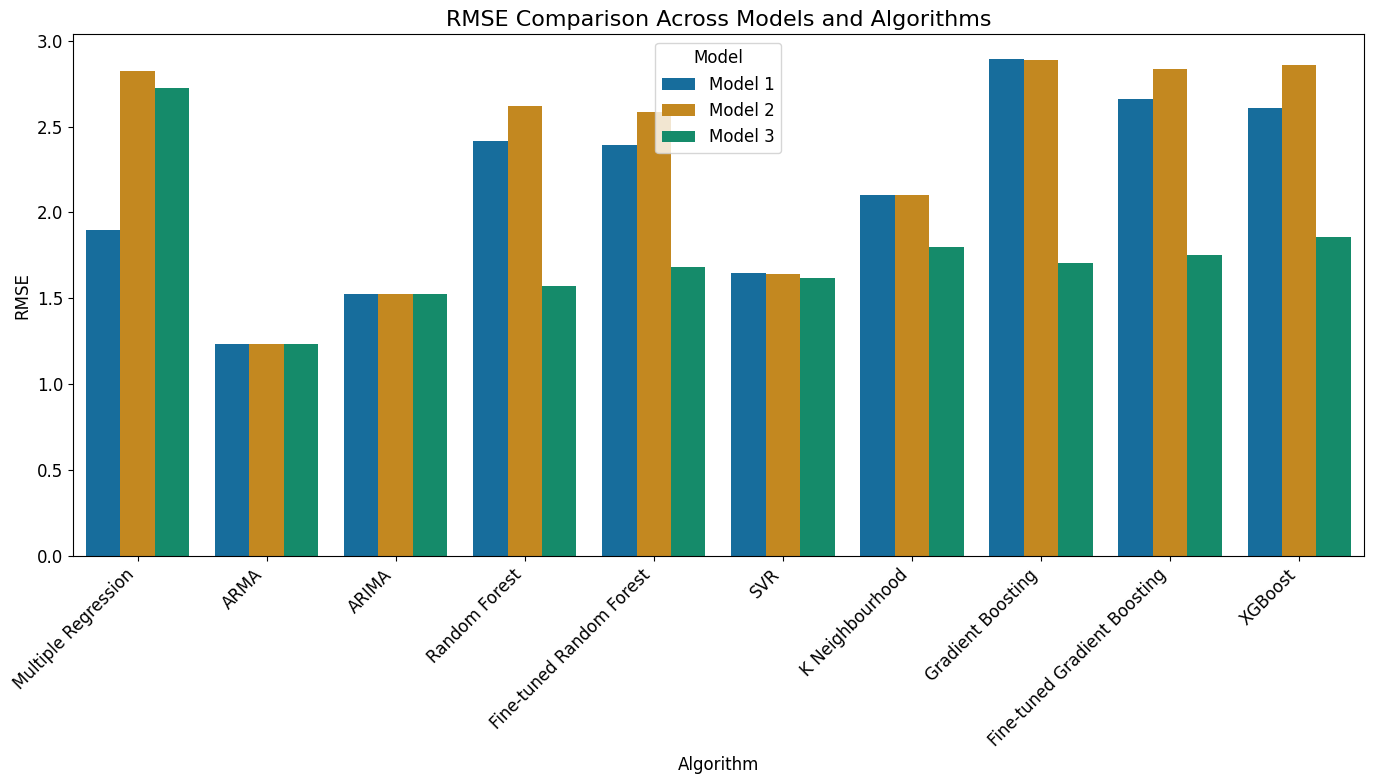

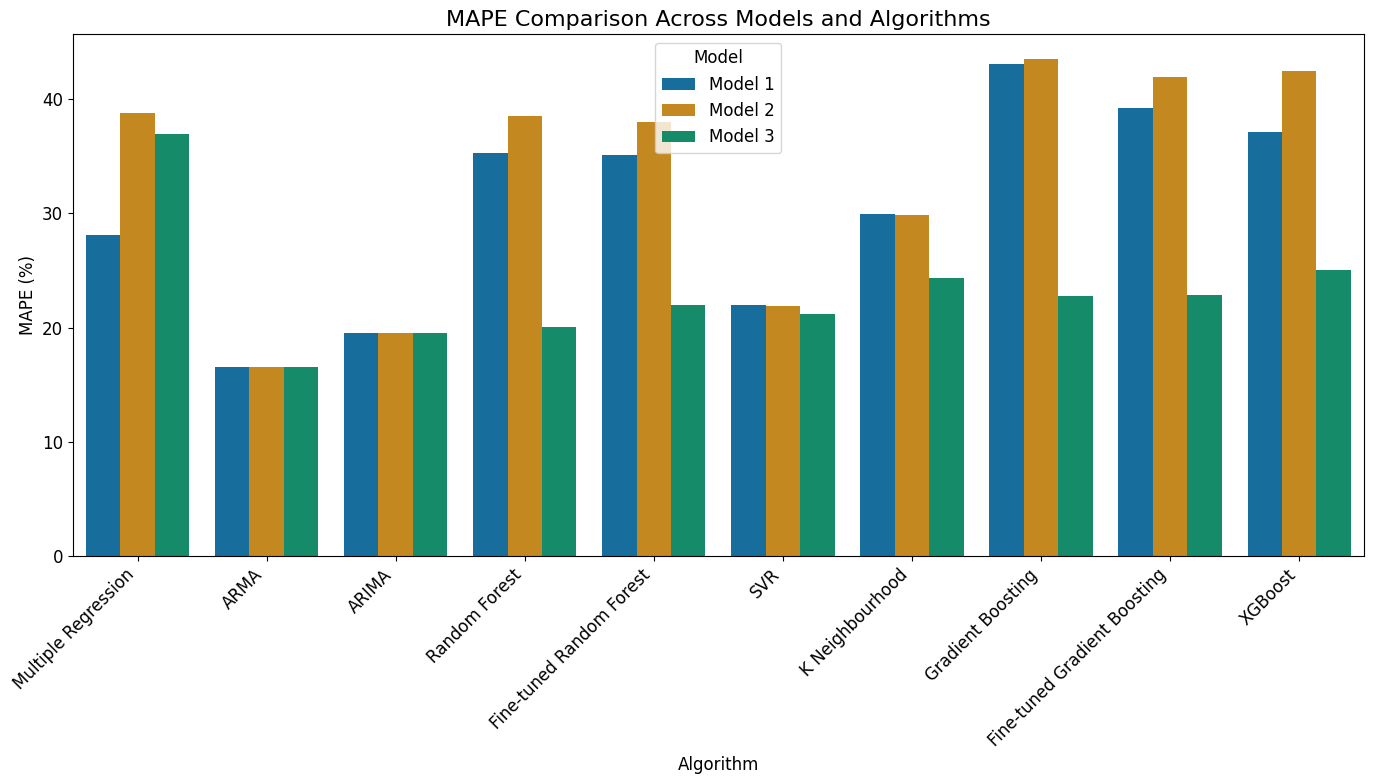

All graphical representations have been saved as PNG files.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/eco723_data/final_data.csv', parse_dates=['year'])
df = df.sort_values('year').reset_index(drop=True)

# Define feature sets for each model
feature_sets = {
    "Model 1": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod'],
    "Model 2": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod', 'exchange_rate'],
    "Model 3": ['interest_rate', 'money_supply', 'exports', 'imports', 'ind_prod',
                'exchange_rate', 'for_ex_reserve']
}

# Train-test split (last 20% as test set)
split_idx = int(len(df) * 0.833)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Set up plotting style
# plt.style.use('seaborn-whitegrid') # This style might not be available
sns.set_palette('colorblind')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 8)})

def plot_predictions(y_actual_train, y_pred_train, y_actual_test, y_pred_test, model_name, algorithm):
    """Plot actual vs predicted values with custom styling for both train and test sets"""
    plt.figure(figsize=(12, 6))
    dates_train = train['year']
    dates_test = test['year']

    # Plot actual vs predicted over time for training data
    plt.plot(dates_train, y_actual_train, 'b-', linewidth=2, label='Actual Inflation (Train)', alpha=0.8)
    plt.plot(dates_train, y_pred_train, 'r--', linewidth=2, label='Predicted Inflation (Train)', alpha=0.8)

    # Plot actual vs predicted over time for test data
    plt.plot(dates_test, y_actual_test, 'g-', linewidth=2, label='Actual Inflation (Test)', alpha=0.8)
    plt.plot(dates_test, y_pred_test, 'm--', linewidth=2, label='Predicted Inflation (Test)', alpha=0.8)


    # Add labels and title for time series plot
    plt.title(f'Actual vs Predicted Inflation over Time: {model_name} ({algorithm})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inflation Rate', fontsize=12)
    plt.legend()

    # Format date axis
    plt.gcf().autofmt_xdate()

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    #plt.savefig(f"{model_name.replace(' ', '_')}_{algorithm.replace(' ', '_')}_time_series.png", dpi=300)
    plt.show()


# Define hyperparameter grids for fine-tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9]
}

# Define Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Fine-tuning function
def fine_tune_models(X_train, y_train):
    # Initialize the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Random Forest Hyperparameter Tuning
    rf = RandomForestRegressor(random_state=42)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
    grid_search_rf.fit(X_train_scaled, y_train)
    best_params_rf = grid_search_rf.best_params_

    # Gradient Boosting Hyperparameter Tuning
    gb = GradientBoostingRegressor(random_state=42)
    grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=tscv, scoring='neg_mean_squared_error')
    grid_search_gb.fit(X_train_scaled, y_train)
    best_params_gb = grid_search_gb.best_params_

    return best_params_rf, best_params_gb

def train_and_predict(model_name, features, best_params_rf, best_params_gb):
    """Train models and generate predictions for a given feature set"""
    X_train = train[features]
    y_train = train['inf_rate']
    X_test = test[features]
    y_test = test['inf_rate']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        "Multiple Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(),
        "K Neighbourhood": KNeighborsRegressor(),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Fine-tuned Random Forest": RandomForestRegressor(**best_params_rf, random_state=42),
        "Fine-tuned Gradient Boosting": GradientBoostingRegressor(**best_params_gb, random_state=42)
    }

    # Train and predict for ML models
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        plot_predictions(y_train, y_pred_train, y_test, y_pred_test, model_name, name)

    # ARMA model (univariate)
    try:
        arma = ARIMA(y_train, order=(1, 0, 1)).fit()
        y_pred_train_arma = arma.predict(start=0, end=len(y_train)-1)
        y_pred_test_arma = arma.forecast(steps=len(y_test))
        plot_predictions(y_train, y_pred_train_arma, y_test, y_pred_test_arma, model_name, "ARMA")
    except Exception as e:
        print(f"ARMA model failed for {model_name}: {e}")


    # ARIMA model (univariate)
    try:
        arima = ARIMA(y_train, order=(1, 1, 1)).fit()
        y_pred_train_arima = arima.predict(start=0, end=len(y_train)-1)
        y_pred_test_arima = arima.forecast(steps=len(y_test))
        plot_predictions(y_train, y_pred_train_arima, y_test, y_pred_test_arima, model_name, "ARIMA")
    except Exception as e:
        print(f"ARIMA model failed for {model_name}: {e}")


# Create comparison plots for all models
def create_comparison_plots():
    """Create comparison plots across models and algorithms"""
    # Prepare data for comparison
    comparison_data = []
    algorithms = [
        "Multiple Regression", "ARMA", "ARIMA", "Random Forest", "Fine-tuned Random Forest",
        "SVR", "K Neighbourhood", "Gradient Boosting", "Fine-tuned Gradient Boosting", "XGBoost"
    ]

    for model_name in feature_sets.keys():
        # Get predictions for the model
        # Need to re-train here to get predictions for all models for comparison plot
        X_train = train[feature_sets[model_name]]
        y_train = train['inf_rate']
        X_test = test[feature_sets[model_name]]
        y_test = test['inf_rate']

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fine-tune models to get best parameters for the comparison plot
        best_params_rf, best_params_gb = fine_tune_models(X_train, y_train)

        models = {
            "Multiple Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "SVR": SVR(),
            "K Neighbourhood": KNeighborsRegressor(),
            "Gradient Boosting": GradientBoostingRegressor(random_state=42),
            "XGBoost": XGBRegressor(random_state=42),
            "Fine-tuned Random Forest": RandomForestRegressor(**best_params_rf, random_state=42),
            "Fine-tuned Gradient Boosting": GradientBoostingRegressor(**best_params_gb, random_state=42)
        }

        predictions = {}
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            predictions[name] = model.predict(X_test_scaled)

        # ARMA and ARIMA predictions (need to handle separately as they don't use scaled features in the same way)
        try:
            arma = ARIMA(y_train, order=(1, 0, 1)).fit()
            predictions["ARMA"] = arma.forecast(steps=len(y_test))
        except:
            pass # Handle potential errors

        try:
            arima = ARIMA(y_train, order=(1, 1, 1)).fit()
            predictions["ARIMA"] = arima.forecast(steps=len(y_test))
        except:
            pass # Handle potential errors


        for algo in algorithms:
            if algo in predictions:
                # Calculate performance metrics
                rmse = np.sqrt(mean_squared_error(y_test, predictions[algo]))
                mape = mean_absolute_percentage_error(y_test, predictions[algo]) * 100

                comparison_data.append({
                    'Model': model_name,
                    'Algorithm': algo,
                    'RMSE': rmse,
                    'MAPE': mape
                })

    # Create DataFrame for comparison
    comparison_df = pd.DataFrame(comparison_data)

    # Plot RMSE comparison
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Algorithm', y='RMSE', hue='Model', data=comparison_df)
    plt.title('RMSE Comparison Across Models and Algorithms', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('RMSE')
    plt.legend(title='Model')
    plt.tight_layout()
    #plt.savefig('RMSE_Comparison.png', dpi=300)
    plt.show()

    # Plot MAPE comparison
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Algorithm', y='MAPE', hue='Model', data=comparison_df)
    plt.title('MAPE Comparison Across Models and Algorithms', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('MAPE (%)')
    plt.legend(title='Model')
    plt.tight_layout()
    #plt.savefig('MAPE_Comparison.png', dpi=300)
    plt.show()

# Main execution
for model_name, features in feature_sets.items():
    print(f"Fine-tuning and predicting for {model_name}...")
    X_train = train[features]
    y_train = train['inf_rate']
    best_params_rf, best_params_gb = fine_tune_models(X_train, y_train)
    train_and_predict(model_name, features, best_params_rf, best_params_gb)

create_comparison_plots()

print("All graphical representations have been saved as PNG files.")